<a href="https://colab.research.google.com/github/Dih08/Cancer/blob/main/cancer_classifica_o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# Isso abrirá um seletor de arquivos para você enviar o ZIP
uploaded = files.upload()


Saving archive (2).zip to archive (2).zip


In [ ]:
!unzip archive\ \(2\).zip

Archive:  archive (2).zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_dataset/no/28 no.jpg  
  inflating: b

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import shutil
import itertools
import pathlib
from PIL import Image, ImageFile
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Cria o DataFrame
data_dir = '/content/brain_tumor_dataset/'
filepaths = []
labels = []
for label in os.listdir(data_dir):
    if label in ['yes', 'no']:
        for file in os.listdir(os.path.join(data_dir, label)):
            filepaths.append(os.path.join(data_dir, label, file))
            labels.append(label)

df = pd.DataFrame({'File_paths': filepaths, 'Labels': labels})
print(df.head())
print(df.tail())
print(df.shape)

                                   File_paths Labels
0   /content/brain_tumor_dataset/no/25 no.jpg     no
1    /content/brain_tumor_dataset/no/no 3.jpg     no
2  /content/brain_tumor_dataset/no/48 no.jpeg     no
3   /content/brain_tumor_dataset/no/no 95.jpg     no
4   /content/brain_tumor_dataset/no/no 5.jpeg     no
                                    File_paths Labels
248  /content/brain_tumor_dataset/yes/Y242.JPG    yes
249  /content/brain_tumor_dataset/yes/Y181.jpg    yes
250   /content/brain_tumor_dataset/yes/Y96.jpg    yes
251  /content/brain_tumor_dataset/yes/Y157.JPG    yes
252  /content/brain_tumor_dataset/yes/Y250.jpg    yes
(253, 2)


In [ ]:
# Célula 3: Divisão dos Dados
# Divide o DataFrame em conjuntos de treinamento, validação e teste.
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Labels'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['Labels'])

print(f"Número de amostras de treino: {len(train_df)}")
print(f"Número de amostras de validação: {len(val_df)}")
print(f"Número de amostras de teste: {len(test_df)}")

Número de amostras de treino: 161
Número de amostras de validação: 41
Número de amostras de teste: 51


In [ ]:
# Célula 4: Definição das Transformações
# Define as transformações de imagem para redimensionamento, normalização e aumento de dados.
# Aumento de dados (data augmentation) é aplicado apenas no conjunto de treino.
image_size = (128, 128)
mean = [0.485, 0.456, 0.406]  # Valores padrão para redes pré-treinadas no ImageNet
std = [0.229, 0.224, 0.225]

# Transformações para o conjunto de treino (com aumento de dados)
train_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Transformações para os conjuntos de validação e teste (apenas redimensionamento e normalização)
val_test_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


In [ ]:
# Célula 5: Criação da Classe Customizada para o Dataset
# Uma classe personalizada que herda de torch.utils.data.Dataset
# para carregar imagens e aplicar transformações.
class BrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.label_map = {'no': 0, 'yes': 1}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        label_str = self.dataframe.iloc[idx, 1]

        # Converte a imagem para o formato RGB
        image = Image.open(img_path).convert('RGB')

        # Aplica as transformações, se houver
        if self.transform:
            image = self.transform(image)

        label = self.label_map[label_str]

        return image, torch.tensor(label, dtype=torch.long)


In [ ]:
# Célula 6: Criação dos DataLoaders
# Cria instâncias do Dataset e do DataLoader para cada conjunto de dados.
train_dataset = BrainTumorDataset(train_df, transform=train_transforms)
val_dataset = BrainTumorDataset(val_df, transform=val_test_transforms)
test_dataset = BrainTumorDataset(test_df, transform=val_test_transforms)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Célula 7: Definição da Arquitetura do Modelo
# Define uma rede neural convolucional (CNN) simples usando PyTorch.
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * (image_size[0] // 8) * (image_size[1] // 8), 128)
        self.fc2 = nn.Linear(128, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 64 * (image_size[0] // 8) * (image_size[1] // 8))
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
# Instancia o modelo
model = SimpleCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"Usando o dispositivo: {device}")

Usando o dispositivo: cuda


In [ ]:
# Célula 8: Configuração do Treinamento
# Define a função de perda (loss function), o otimizador e o número de épocas.
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 15

In [ ]:
# Célula 9: Loop de Treinamento
# Implementa o loop principal para treinar o modelo.
# Ele percorre os dados de treino e validação, calcula a perda e a acurácia.
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    # FASE DE TREINAMENTO
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # FASE DE VALIDAÇÃO
    model.eval()
    running_loss_val = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss_val = criterion(outputs, labels)
            running_loss_val += loss_val.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_loss_val = running_loss_val / len(val_dataset)
    epoch_acc_val = correct_val / total_val
    val_losses.append(epoch_loss_val)
    val_accuracies.append(epoch_acc_val)

    print(f'Época [{epoch+1}/{num_epochs}], '
          f'Perda de Treino: {epoch_loss:.4f}, Acurácia de Treino: {epoch_acc:.4f}, '
          f'Perda de Validação: {epoch_loss_val:.4f}, Acurácia de Validação: {epoch_acc_val:.4f}')

Época [1/15], Perda de Treino: 0.7226, Acurácia de Treino: 0.5652, Perda de Validação: 0.6030, Acurácia de Validação: 0.6098
Época [2/15], Perda de Treino: 0.6032, Acurácia de Treino: 0.6646, Perda de Validação: 0.5563, Acurácia de Validação: 0.6585
Época [3/15], Perda de Treino: 0.5487, Acurácia de Treino: 0.7516, Perda de Validação: 0.5261, Acurácia de Validação: 0.7561
Época [4/15], Perda de Treino: 0.5227, Acurácia de Treino: 0.7516, Perda de Validação: 0.5472, Acurácia de Validação: 0.7317
Época [5/15], Perda de Treino: 0.4991, Acurácia de Treino: 0.7888, Perda de Validação: 0.5265, Acurácia de Validação: 0.8049
Época [6/15], Perda de Treino: 0.5004, Acurácia de Treino: 0.8261, Perda de Validação: 0.5166, Acurácia de Validação: 0.7561
Época [7/15], Perda de Treino: 0.4174, Acurácia de Treino: 0.7888, Perda de Validação: 0.5291, Acurácia de Validação: 0.7805
Época [8/15], Perda de Treino: 0.4251, Acurácia de Treino: 0.7764, Perda de Validação: 0.5038, Acurácia de Validação: 0.8049


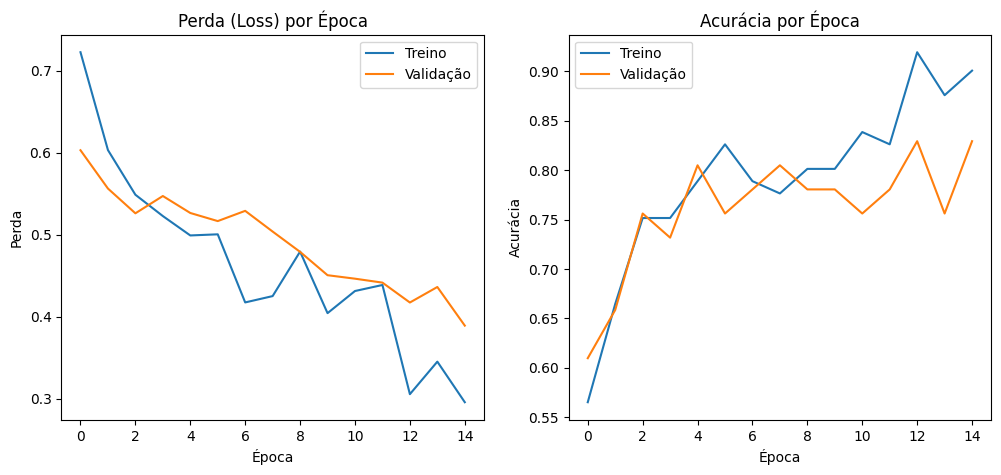

In [ ]:
# Célula 10: Visualização dos Gráficos de Perda e Acurácia
# Plota os gráficos para visualizar o desempenho do modelo ao longo das épocas.
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Treino')
plt.plot(val_losses, label='Validação')
plt.title('Perda (Loss) por Época')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Treino')
plt.plot(val_accuracies, label='Validação')
plt.title('Acurácia por Época')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.show()

Matriz de Confusão:
[[17  3]
 [10 21]]

Relatório de Classificação:
              precision    recall  f1-score   support

          no       0.63      0.85      0.72        20
         yes       0.88      0.68      0.76        31

    accuracy                           0.75        51
   macro avg       0.75      0.76      0.74        51
weighted avg       0.78      0.75      0.75        51



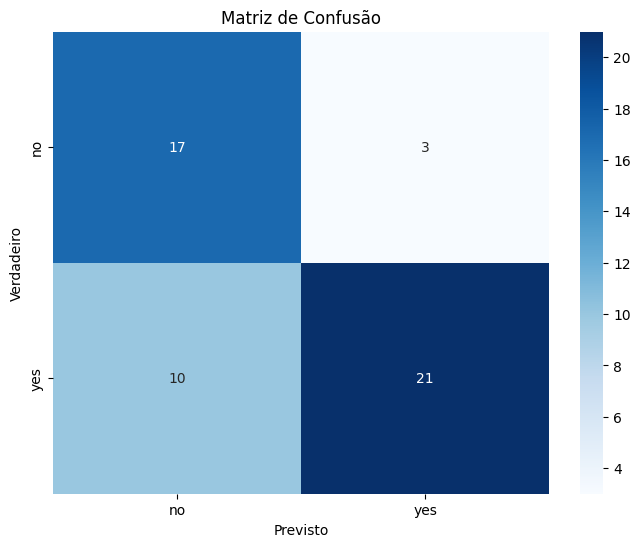

Caminho da imagem de exemplo: /content/brain_tumor_dataset/no/42 no.jpg
Rótulo verdadeiro: no
Previsão do modelo: no


In [ ]:
# Célula 11: Avaliação Final no Conjunto de Teste
# Avalia o modelo final usando o conjunto de teste para métricas de desempenho.
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Geração de Relatórios de Desempenho
cm = confusion_matrix(test_labels, test_preds)
print("Matriz de Confusão:")
print(cm)

class_names = ['no', 'yes']
report = classification_report(test_labels, test_preds, target_names=class_names)
print("\nRelatório de Classificação:")
print(report)

# Visualização da Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.show()

# Célula 12: Função para Previsão de uma Única Imagem
# Uma função utilitária para fazer previsões em uma nova imagem.
def predict_single_image(model, image_path, transform, device):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)

    return 'yes' if predicted.item() == 1 else 'no'

# Exemplo de uso da função de previsão
# Pega uma imagem do conjunto de teste para demonstrar a previsão
sample_image_path = test_df.iloc[0]['File_paths']
prediction = predict_single_image(model, sample_image_path, val_test_transforms, device)
true_label = test_df.iloc[0]['Labels']

print(f"Caminho da imagem de exemplo: {sample_image_path}")
print(f"Rótulo verdadeiro: {true_label}")
print(f"Previsão do modelo: {prediction}")

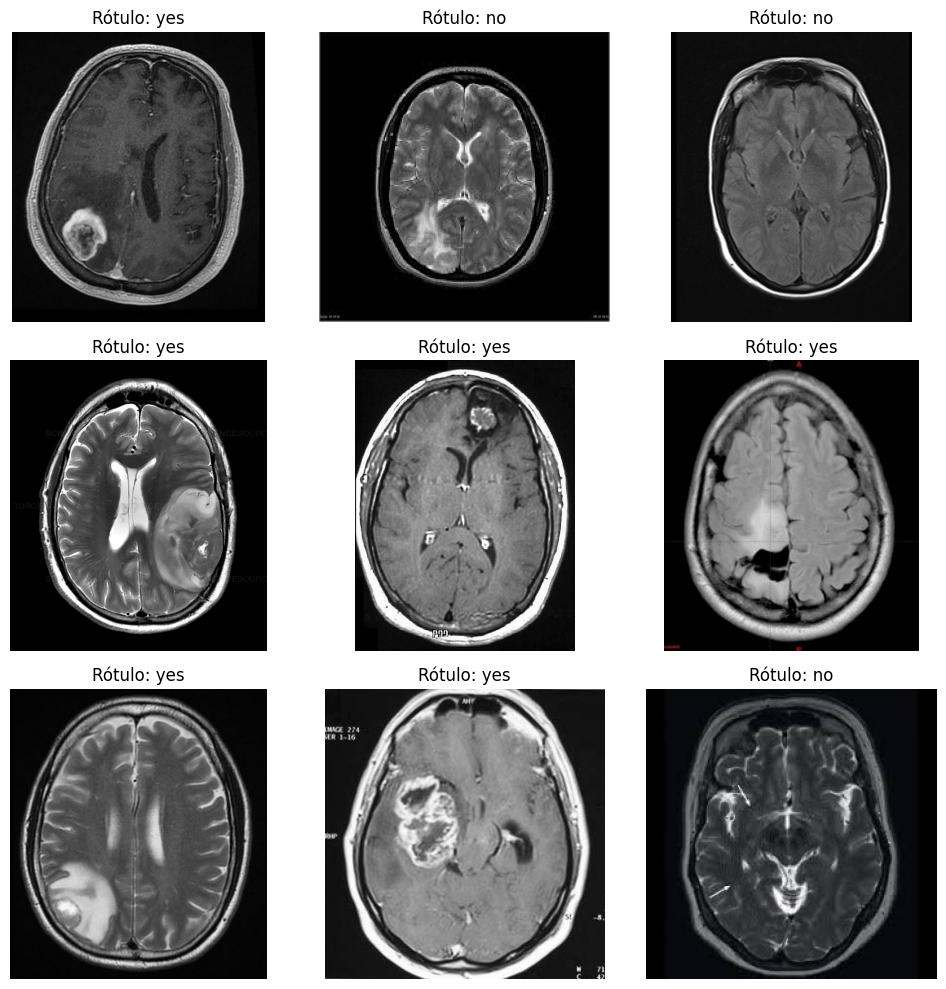


Visualização de uma imagem após as transformações (conjunto de treino):


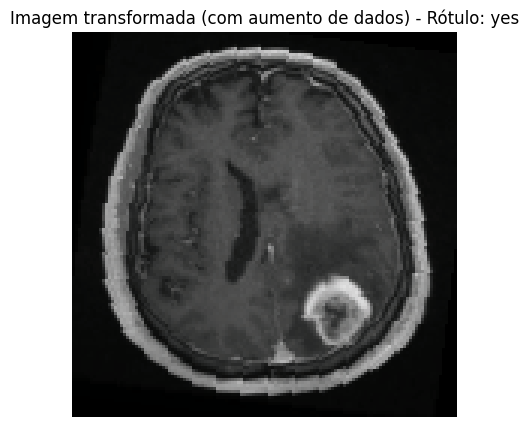

In [ ]:
# Célula 2.1: Visualização de Amostras de Imagens
# Mostra uma seleção de 9 imagens do DataFrame para inspeção visual.

# Pega uma amostra aleatória de 9 imagens do DataFrame
sample_df = df.sample(9, random_state=42)
sample_filepaths = sample_df['File_paths'].values
sample_labels = sample_df['Labels'].values

plt.figure(figsize=(10, 10))
for i, (filepath, label) in enumerate(zip(sample_filepaths, sample_labels)):
    plt.subplot(3, 3, i + 1)

    # Abre a imagem
    image = Image.open(filepath)

    # Exibe a imagem
    plt.imshow(image, cmap='gray')

    # Adiciona o título com o rótulo
    plt.title(f"Rótulo: {label}")

    plt.axis('off')

plt.tight_layout()
plt.show()

# Para visualizar as transformações, podemos pegar uma imagem de exemplo e aplicar as transforms
print("\nVisualização de uma imagem após as transformações (conjunto de treino):")
example_path = sample_filepaths[0]
example_image = Image.open(example_path).convert('RGB')
transformed_image = train_transforms(example_image)

# A imagem transformada é um tensor, então precisamos convertê-la de volta para numpy para visualização
# Desfazendo a normalização para visualização
# Nota: esta etapa é apenas para visualização. A rede neural usa a imagem normalizada.
inv_normalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
transformed_image_np = inv_normalize(transformed_image).permute(1, 2, 0).numpy().clip(0, 1)

plt.figure(figsize=(5, 5))
plt.imshow(transformed_image_np)
plt.title(f"Imagem transformada (com aumento de dados) - Rótulo: {sample_labels[0]}")
plt.axis('off')
plt.show()